In [1]:
import pandas as pd
import os, re
import csv
import numpy as np

In [2]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [3]:
chdir = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [5]:
# Metadata for specific SFC configurations
exp_ls = "exp11"
exp_rs = "exp-7-3-5"
vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [6]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for i in range(len(lines)):
                try:
                    value = float(lines[i].strip()) / 1000
                except ValueError:
                    value=np.nan
                tmp.append(value)
    else:
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value =np.nan
                tmp.append(value)
                
    return tmp

In [7]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                try:
                    value = float(line.strip().split(',')[index])
                except ValueError:
                    value = np.nan
                stat.append(value)

    return list(map(lambda x:float(x), stat[:-1]))

In [11]:
latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
len(latency)

177

In [12]:
tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
len(tx_stats)

178

In [13]:
rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
len(rx_stats)

178

In [14]:
firewall_instructions = parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)
len(firewall_instructions)

176

In [15]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",'mem-stores','iTLB-loads','mem-loads',]

In [16]:
def make_df():
    tmp = []
    dic = dict()

    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")

    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)


In [17]:
df = make_df()

<Axes: >

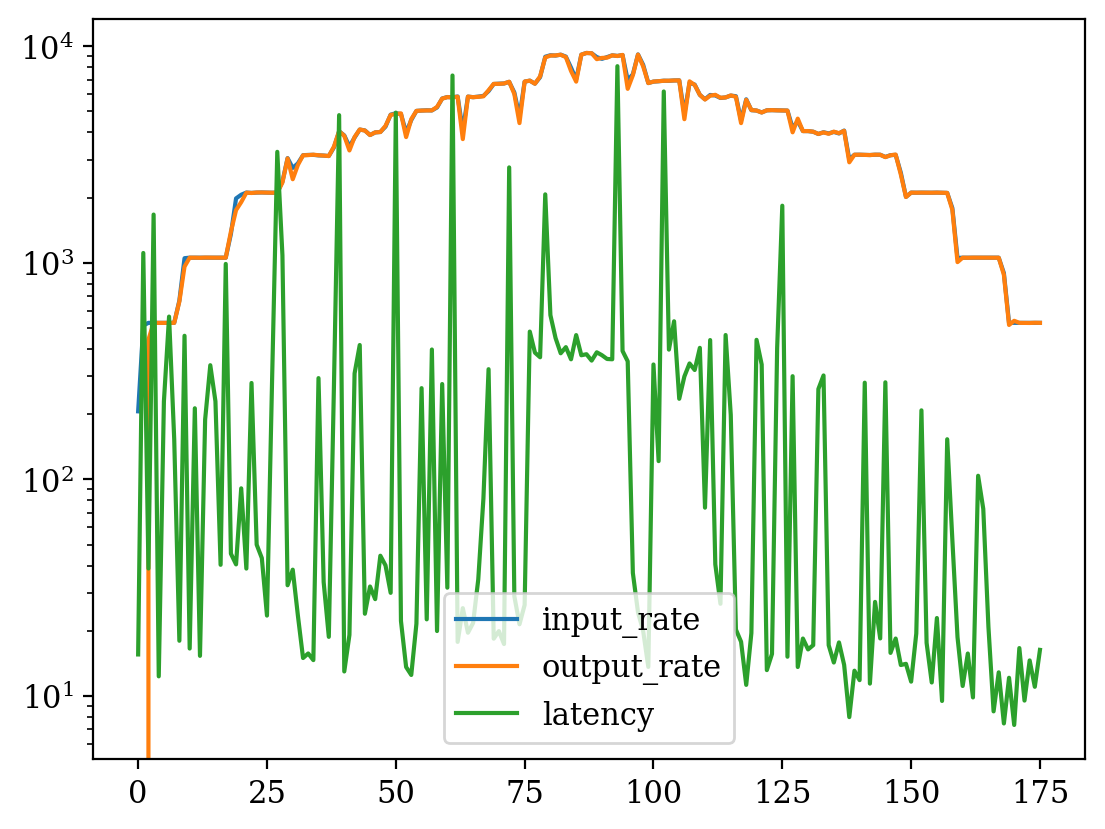

In [18]:
df.iloc[:, :3].plot(logy=True)

<Axes: >

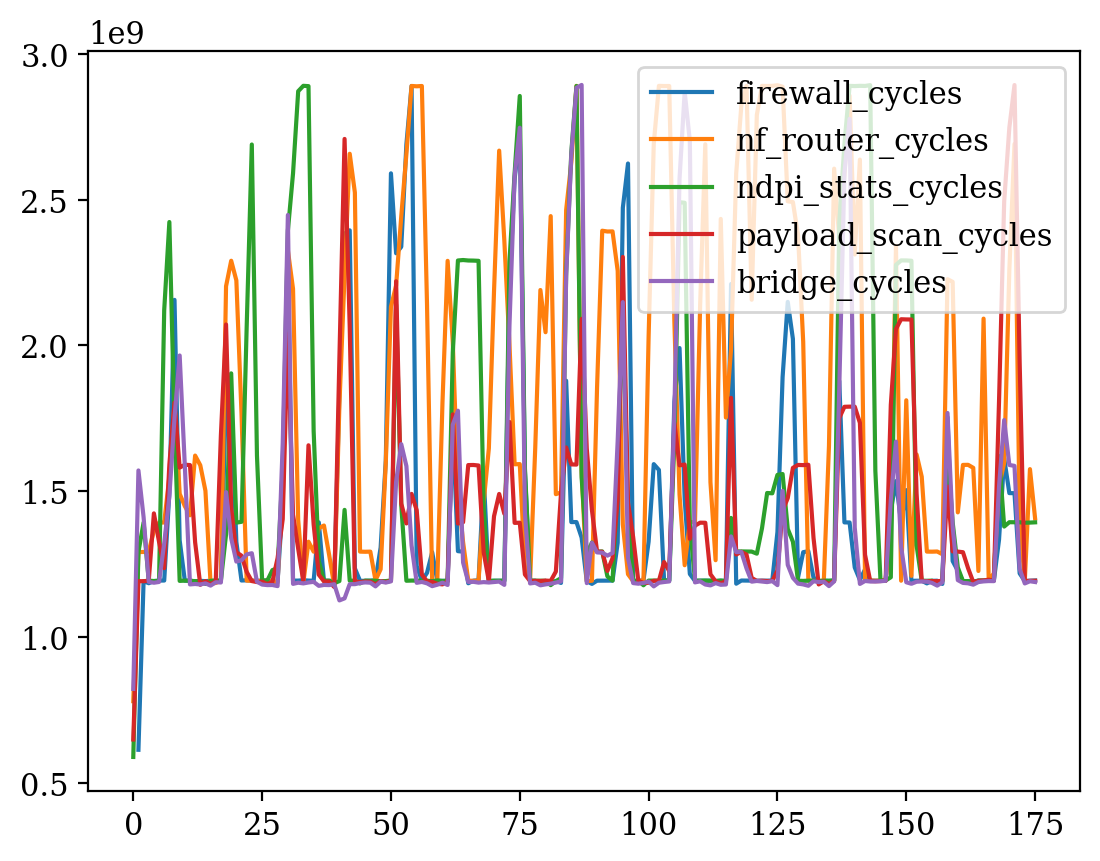

In [19]:
df[["firewall_cycles","nf_router_cycles","ndpi_stats_cycles","payload_scan_cycles","bridge_cycles"]].plot()

In [20]:
abs_path = os.path.join("..\\linear\\datasets", "load_stimulus_"+ exp_ls +".csv")
df.to_csv(abs_path, sep=',')


# Resource stimulus

In [21]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for i in range(len(lines)):
                if i % 2 != 0:  # Check if the index is odd
                    value = float(lines[i].strip()) / 1000
                    tmp.append(value)
    else:
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)
                
    return tmp

In [22]:
latency_1 = parse_seq("resource_stimulus", exp_rs, "latency.csv")
len(latency_1)

46

In [23]:
tx_stats_1 = parse_seq("resource_stimulus", exp_rs, "tx_stats.csv")
len(tx_stats_1)

48

In [24]:
def make_df_rl(exp_rs):
    tmp = []
    dic = dict()

    tx_stats = parse_seq("resource_stimulus", exp_rs, "tx_stats.csv")
    rx_stats = parse_seq("resource_stimulus", exp_rs, "rx_stats.csv")
    latency = parse_seq("resource_stimulus", exp_rs, "latency.csv")

    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("resource_stimulus", exp_rs, "firewall.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("resource_stimulus", exp_rs, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)

In [25]:
df_rl = make_df_rl("exp-4-1-1")
df_rl

,input_rate,output_rate,latency,firewall_instructions,nf_router_instructions,ndpi_stats_instructions,payload_scan_instructions,bridge_instructions,firewall_branches,nf_router_branches,...,firewall_iTLB-loads,nf_router_iTLB-loads,ndpi_stats_iTLB-loads,payload_scan_iTLB-loads,bridge_iTLB-loads,firewall_mem-loads,nf_router_mem-loads,ndpi_stats_mem-loads,payload_scan_mem-loads,bridge_mem-loads
0,441.917008,388.046987,9.228,1.008563e+10,1.035043e+10,9.973966e+09,9.993891e+09,1.006432e+10,1.987173e+09,2.042689e+09,...,37.0,19.0,102.0,139.0,102.0,0.0,0.0,0.0,0.0,0.0
1,1788.785283,2073.219500,11.939,9.979306e+09,1.024632e+10,9.944593e+09,1.007163e+10,1.007007e+10,1.970529e+09,2.025215e+09,...,75.0,75.0,83.0,117.0,67.0,0.0,0.0,0.0,0.0,0.0
2,2113.113827,2111.239645,7.644,9.405369e+09,1.033223e+10,9.776250e+09,9.924271e+09,9.926508e+09,1.854243e+09,2.038131e+09,...,33.0,25.0,67.0,33.0,58.0,0.0,0.0,0.0,0.0,0.0
3,2113.166489,2110.474065,15.613,9.834929e+09,1.013403e+10,9.845694e+09,9.985913e+09,9.969789e+09,1.949817e+09,2.010363e+09,...,65.0,74.0,185.0,18.0,111.0,0.0,0.0,0.0,0.0,0.0
4,2113.111725,2108.908024,11.677,9.937327e+09,9.804298e+09,9.921536e+09,1.006559e+10,1.005732e+10,1.964574e+09,1.940120e+09,...,67.0,67.0,25.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
5,2112.899709,2110.256254,14.851,9.821285e+09,1.011172e+10,9.801057e+09,1.008320e+10,9.933352e+09,1.946776e+09,2.006434e+09,...,63.0,79.0,81.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0
6,2113.002296,2110.013801,14.096,9.929401e+09,1.023831e+10,9.706146e+09,1.020378e+10,9.856123e+09,1.963207e+09,2.024846e+09,...,86.0,70.0,0.0,884.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2112.981408,2107.952886,8.519,9.755713e+09,1.011359e+10,9.829925e+09,1.018115e+10,9.960949e+09,1.934522e+09,2.006813e+09,...,8.0,8.0,4584.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0
8,2112.925610,2109.726266,10.039,9.800254e+09,1.010330e+10,1.002090e+10,1.015700e+10,1.014867e+10,1.944422e+09,2.006186e+09,...,37.0,9.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2113.304651,2111.138705,14.012,9.931672e+09,1.023619e+10,1.003276e+10,1.017695e+10,1.015901e+10,1.963080e+09,2.024438e+09,...,0.0,25.0,8.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

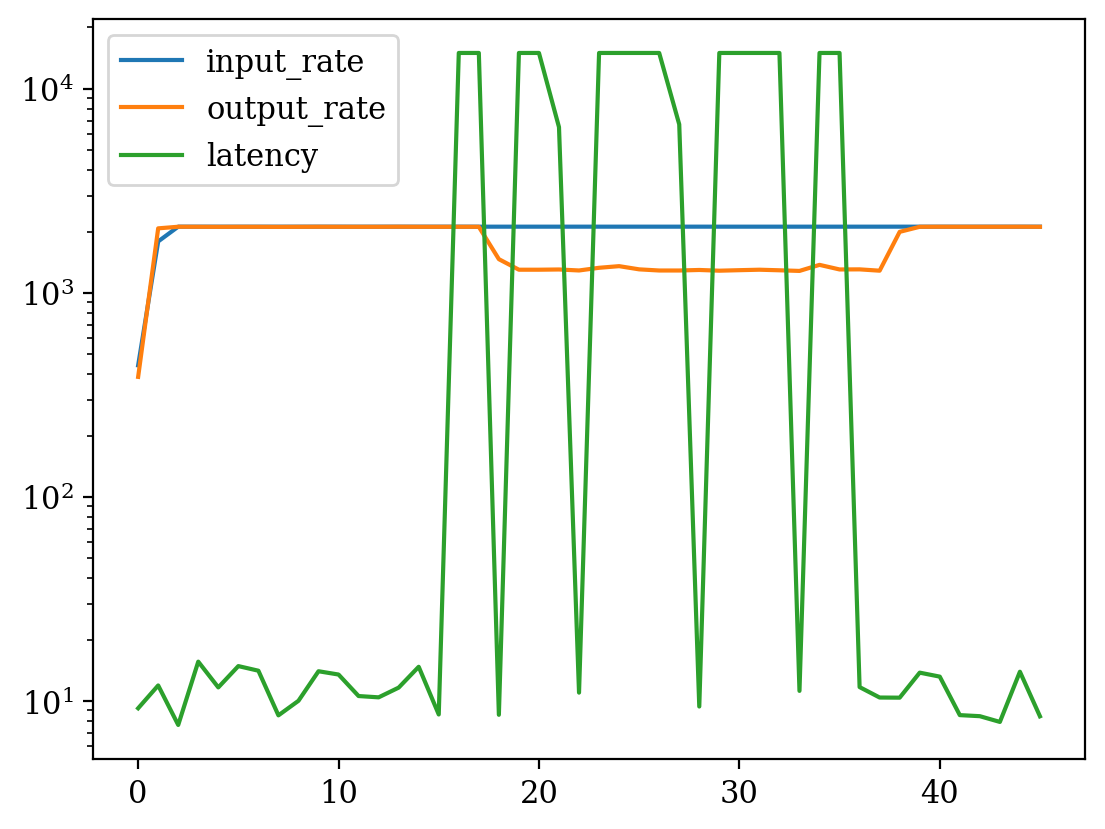

In [26]:
df_rl.iloc[:, :3].plot(logy=True)

In [27]:
exp_rs=["exp-3-1-2","exp-3-1-3","exp-3-1-4","exp-3-1-5","exp-3-3-1","exp-3-3-2","exp-3-3-3","exp-3-3-4","exp-3-3-5","exp-4-1-1","exp-4-1-2","exp-4-1-3","exp-4-1-4","exp-4-1-5","exp-4-3-1","exp-4-3-2","exp-4-3-3","exp-4-3-4","exp-4-3-5","exp-5-1-1","exp-5-1-2","exp-5-1-3","exp-5-1-4","exp-5-1-5","exp-5-3-1","exp-5-3-2","exp-5-3-3","exp-5-3-4","exp-5-3-5","exp-6-1-1","exp-6-1-2","exp-6-1-3","exp-6-1-4","exp-6-1-5","exp-6-3-1","exp-6-3-2","exp-6-3-3","exp-6-3-4","exp-6-3-5","exp-7-1-1","exp-7-1-2","exp-7-1-3","exp-7-1-4","exp-7-1-5","exp-7-3-1","exp-7-3-2","exp-7-3-3","exp-7-3-4","exp-7-3-5"]
print(exp_rs)
for item in exp_rs:
    df_rl = make_df_rl(item) 
    abs_path = os.path.join("..\\linear\\datasets", "resource_stimulus_"+ item +".csv")
    df_rl.to_csv(abs_path, sep=',')


['exp-3-1-2', 'exp-3-1-3', 'exp-3-1-4', 'exp-3-1-5', 'exp-3-3-1', 'exp-3-3-2', 'exp-3-3-3', 'exp-3-3-4', 'exp-3-3-5', 'exp-4-1-1', 'exp-4-1-2', 'exp-4-1-3', 'exp-4-1-4', 'exp-4-1-5', 'exp-4-3-1', 'exp-4-3-2', 'exp-4-3-3', 'exp-4-3-4', 'exp-4-3-5', 'exp-5-1-1', 'exp-5-1-2', 'exp-5-1-3', 'exp-5-1-4', 'exp-5-1-5', 'exp-5-3-1', 'exp-5-3-2', 'exp-5-3-3', 'exp-5-3-4', 'exp-5-3-5', 'exp-6-1-1', 'exp-6-1-2', 'exp-6-1-3', 'exp-6-1-4', 'exp-6-1-5', 'exp-6-3-1', 'exp-6-3-2', 'exp-6-3-3', 'exp-6-3-4', 'exp-6-3-5', 'exp-7-1-1', 'exp-7-1-2', 'exp-7-1-3', 'exp-7-1-4', 'exp-7-1-5', 'exp-7-3-1', 'exp-7-3-2', 'exp-7-3-3', 'exp-7-3-4', 'exp-7-3-5']


<Axes: >

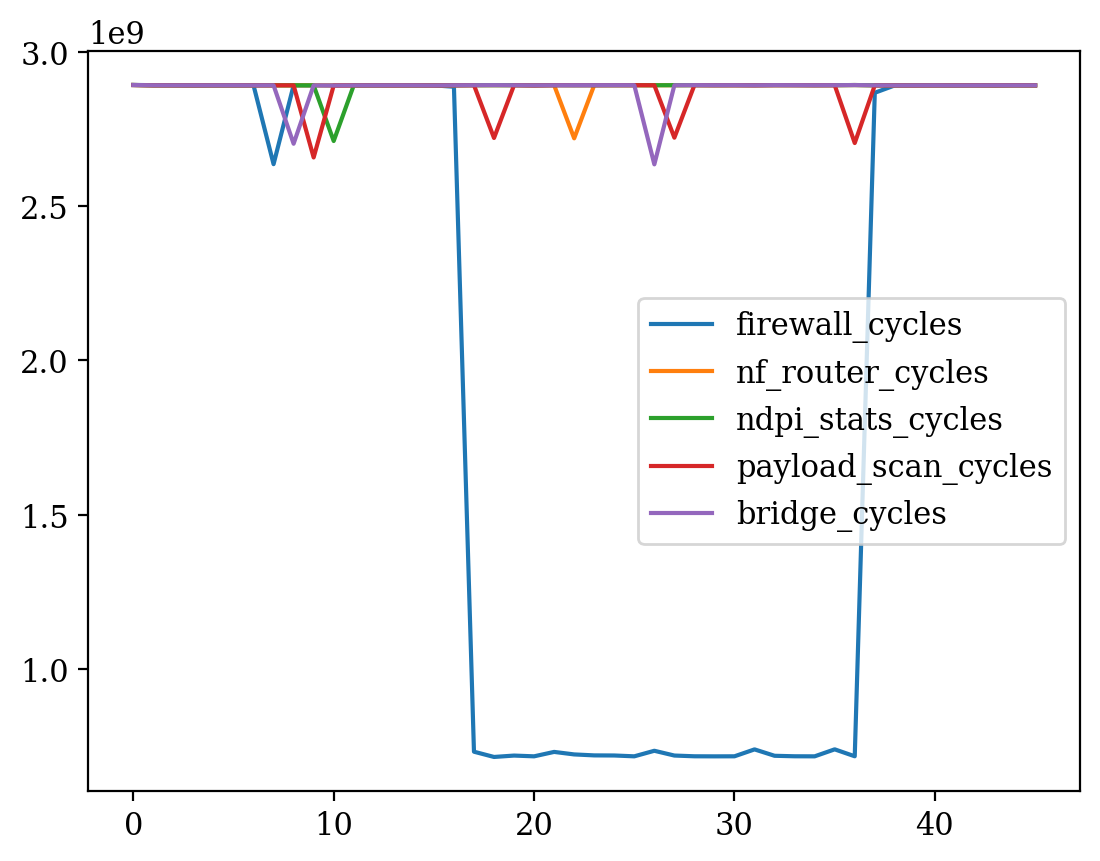

In [28]:
df_rl[["firewall_cycles","nf_router_cycles","ndpi_stats_cycles","payload_scan_cycles","bridge_cycles"]].plot()

# load stimulus-random rate


In [29]:
import re
import numpy as np
exp_rs = "exp-2"

In [30]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "random_rates" else f.readlines()
            for i in range(len(lines)):
                value = float(lines[i].strip()) / 1000
                tmp.append(value)
    else:
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = np.nan
                tmp.append(value)
                
    return tmp

In [31]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                try:
                    value = float(line.strip().split(',')[index])
                except ValueError:
                    value = np.nan
                stat.append(value)

    return list(map(lambda x:float(x), stat[:-1]))

In [33]:
def make_df_rr(exp_rs):
    tmp = []
    dic = dict()

    tx_stats = parse_seq("random_rates", exp_rs, "tx_stats.csv")
    rx_stats = parse_seq("random_rates", exp_rs, "rx_stats.csv")
    latency = parse_seq("random_rates", exp_rs, "latency.csv")

    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("random_rates", exp_rs, "firewall.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("random_rates", exp_rs, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)

In [34]:
df_rl = make_df_rr("exp-2")
df_rl = df_rl.iloc[4:]
df_rl

,input_rate,output_rate,latency,firewall_instructions,nf_router_instructions,ndpi_stats_instructions,payload_scan_instructions,bridge_instructions,firewall_branches,nf_router_branches,...,firewall_iTLB-loads,nf_router_iTLB-loads,ndpi_stats_iTLB-loads,payload_scan_iTLB-loads,bridge_iTLB-loads,firewall_mem-loads,nf_router_mem-loads,ndpi_stats_mem-loads,payload_scan_mem-loads,bridge_mem-loads
4,5725.781112,5724.782513,27.763,5.905996e+09,6.207021e+09,5.082340e+09,6.668214e+09,6.677093e+09,1.175246e+09,1.245315e+09,...,400.0,83.0,0.0,242.0,75.0,0.0,0.0,0.0,0.0,0.0
5,5736.249820,5736.390268,19.562,5.922728e+09,6.172802e+09,5.095697e+09,6.692350e+09,6.688301e+09,1.170316e+09,1.236609e+09,...,0.0,158.0,184.0,148.0,222.0,0.0,0.0,0.0,0.0,0.0
6,5736.516898,5736.496497,44.893,6.018849e+09,6.213046e+09,5.128635e+09,6.677057e+09,6.610962e+09,1.178152e+09,1.249552e+09,...,25.0,9.0,166.0,250.0,175.0,0.0,0.0,0.0,0.0,0.0
7,5735.281889,5735.342075,42.908,6.044018e+09,6.249427e+09,5.097016e+09,6.723396e+09,6.594423e+09,1.193370e+09,1.257399e+09,...,690.0,310.0,282.0,17.0,167.0,0.0,0.0,0.0,0.0,0.0
8,5319.109927,5282.821159,13.414,6.194316e+09,6.457994e+09,4.996293e+09,6.526930e+09,6.724834e+09,1.226218e+09,1.287172e+09,...,785.0,8.0,92.0,9.0,195.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11980,3444.886304,3444.883108,145.722,4.778928e+09,5.534346e+09,4.999571e+09,5.885415e+09,5.686389e+09,9.515541e+08,1.102224e+09,...,717.0,2076.0,1130.0,417.0,373.0,0.0,0.0,0.0,0.0,0.0
11981,3443.520119,3443.564644,144.244,4.918525e+09,5.430560e+09,5.011889e+09,5.756375e+09,5.821108e+09,9.769682e+08,1.084484e+09,...,1392.0,1014.0,983.0,1702.0,1295.0,0.0,0.0,0.0,0.0,0.0
11982,3443.971707,3443.980865,159.994,4.781452e+09,5.394594e+09,4.984724e+09,5.880657e+09,5.692393e+09,9.536020e+08,1.076914e+09,...,695.0,1249.0,0.0,267.0,8.0,0.0,0.0,0.0,0.0,0.0
11983,3444.443950,3444.424431,154.851,4.700215e+09,5.210019e+09,4.944228e+09,5.826695e+09,5.710325e+09,9.359235e+08,1.044996e+09,...,92.0,1518.0,0.0,736.0,9.0,0.0,0.0,0.0,0.0,0.0


In [35]:
latency = parse_seq("random_rates", exp_rs, "latency.csv")
len(latency)

11989

In [36]:
tx_stats_1 = parse_seq("random_rates", exp_rs, "tx_stats.csv")
len(tx_stats_1)

11991

In [37]:
abs_path = os.path.join("..\\linear\\datasets", "random_rates_"+ "exp-2" +".csv")
df_rl.to_csv(abs_path, sep=',')
